In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
data=pd.read_csv('amazon_alexa.tsv',sep='\t')
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [5]:
data.shape

(3150, 5)

In [6]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object

In [7]:
data['verified_reviews'].head()

0                                        Love my Echo!
1                                            Loved it!
2    Sometimes while playing a game, you can answer...
3    I have had a lot of fun with this thing. My 4 ...
4                                                Music
Name: verified_reviews, dtype: object

In [8]:
sam_data=data[['verified_reviews','feedback']]
sam_data.head()

,verified_reviews,feedback
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


In [9]:
sam_data.isnull().sum()

verified_reviews    0
feedback            0
dtype: int64

In [10]:
sam_data.dropna(subset=['verified_reviews'],inplace=True)

In [11]:
sam_data.isnull().sum()

verified_reviews    0
feedback            0
dtype: int64

In [12]:
sam_data['verified_reviews']=sam_data['verified_reviews'].astype(str)
sam_data.shape

(3150, 2)

In [13]:
sam_data['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

Text(0.5, 1.0, 'Feedback for sentimental class')

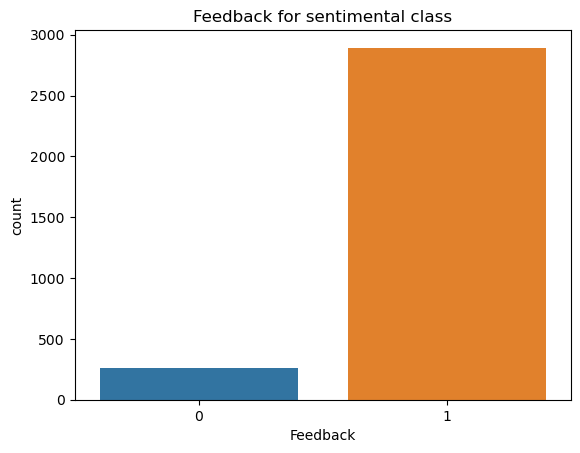

In [14]:
sns.countplot(x='feedback',data=sam_data)
plt.xlabel('Feedback')
plt.title('Feedback for sentimental class')

In [15]:
sam_data['Length']=sam_data['verified_reviews'].apply(len)
sam_data.head()

,verified_reviews,feedback,Length
0,Love my Echo!,1,13
1,Loved it!,1,9
2,"Sometimes while playing a game, you can answer...",1,195
3,I have had a lot of fun with this thing. My 4 ...,1,172
4,Music,1,5


Text(0.5, 0, 'Character Length of Reviews')

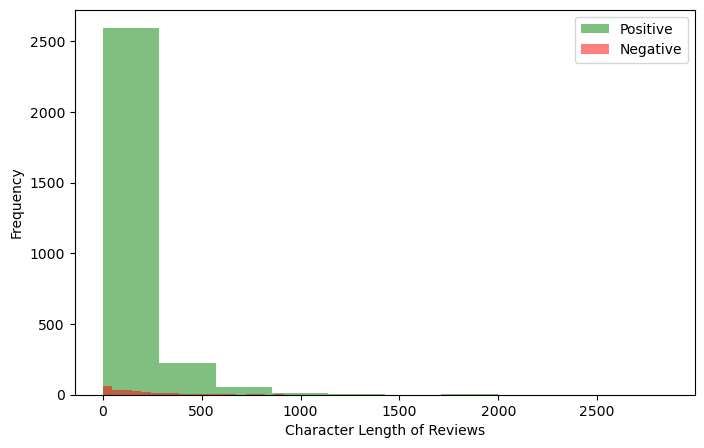

In [16]:
plt.figure(figsize=(8,5))
sam_data[sam_data.feedback==1].Length.plot(kind='hist',color='green',label='Positive',alpha=0.5)
sam_data[sam_data.feedback==0].Length.plot(bins=35,kind='hist',color='red',label='Negative',alpha=0.5)
plt.legend()
plt.xlabel("Character Length of Reviews")

In [17]:
def tokens(words):
    words=re.sub("[^a-zA-Z]"," ",words)
    text=words.lower().split()
    return " ".join(text)

In [18]:
stop_words=stopwords.words('english')
print(stop_words[::10])

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [19]:
service=['echo','dot','amazon','alexa','siri','device']

In [20]:
def stopwords(reviews):
    text=[word.lower() for word in reviews.split() if word.lower() not in stop_words and word.lower() not in service]
    return " ".join(text)


In [21]:
def remove_numbers(text):
    new_text=[]
    for word in text.split():
        if not re.search('\d',word):
            new_text.append(word)
    return ' '.join(new_text)


In [22]:
lem=WordNetLemmatizer()

def lemmatize(text):
    lem_text=[lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)


In [23]:
sam_data['verified_reviews']=sam_data['verified_reviews'].apply(tokens)
sam_data['verified_reviews']=sam_data['verified_reviews'].apply(stopwords)
sam_data['verified_reviews']=sam_data['verified_reviews'].apply(remove_numbers)
sam_data['verified_reviews']=sam_data['verified_reviews'].apply(lemmatize)

In [24]:
sam_data.head()

,verified_reviews,feedback,Length
0,love,1,13
1,loved,1,9
2,sometimes playing game answer question correct...,1,195
3,lot fun thing yr old learns dinosaur control l...,1,172
4,music,1,5


In [25]:
sam_data['verified_reviews'].head(10)

0                                                 love
1                                                loved
2    sometimes playing game answer question correct...
3    lot fun thing yr old learns dinosaur control l...
4                                                music
5    received gift needed another bluetooth somethi...
6    without cellphone cannot use many feature ipad...
7    think th one purchased working getting one eve...
8                                           look great
9    love listened song heard since childhood get n...
Name: verified_reviews, dtype: object

In [26]:
positive=sam_data[sam_data.feedback==1]
negative=sam_data[sam_data.feedback==0]
positive.head()

,verified_reviews,feedback,Length
0,love,1,13
1,loved,1,9
2,sometimes playing game answer question correct...,1,195
3,lot fun thing yr old learns dinosaur control l...,1,172
4,music,1,5


In [27]:
negative.head()

,verified_reviews,feedback,Length
46,like fact answer accurately see real need hous...,0,163
111,sound terrible u want good music get bose,0,53
141,much feature,0,18
162,stopped working week follow command really fun...,0,87
176,sad joke worthless,0,20


In [28]:
positive_words=[]

for review in positive.verified_reviews:
    positive_words.append(review)
positive_words=' '.join(positive_words)
positive_words[:48]

'love loved sometimes playing game answer questio'

In [29]:
negative_words=[]
for review in negative.verified_reviews:
    negative_words.append(review)
negative_words=' '.join(negative_words)
negative_words[:455]

'like fact answer accurately see real need household though good bargain prime day deal sound terrible u want good music get bose much feature stopped working week follow command really fun working sad joke worthless really disappointed plug wall socket time fault checking made assumption company technologically advanced would sell product rechargeable battery could return would apple music boom speaker give flexibility got great sound bass work time s'

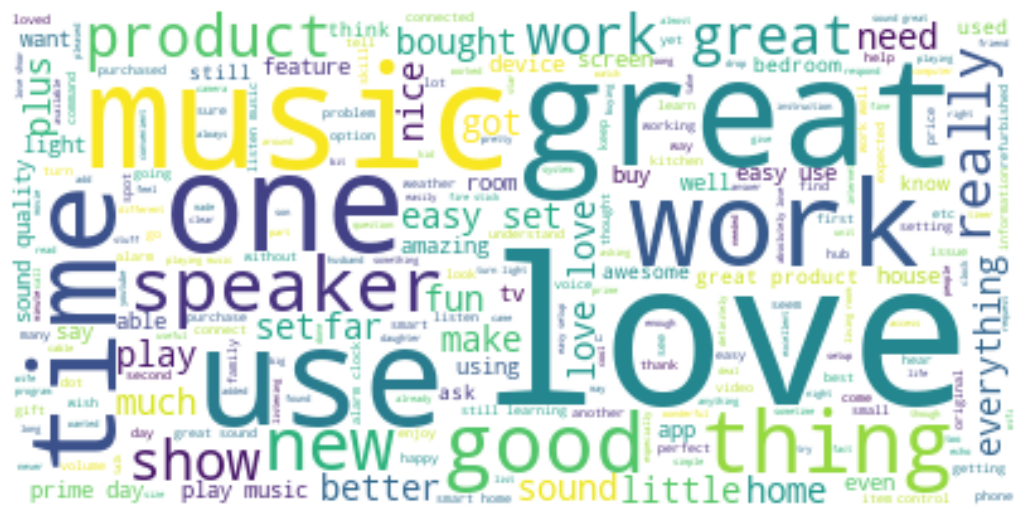

In [30]:
wordcloud=WordCloud(background_color='white',max_words=len(positive_words))

wordcloud.generate(positive_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

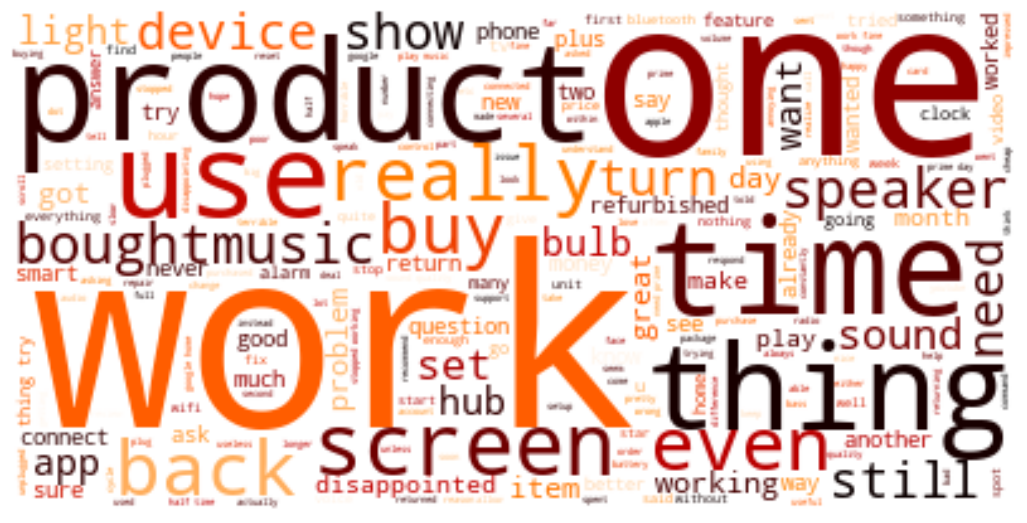

In [31]:
wordcloud=WordCloud(background_color='white',max_words=len(negative_words),colormap='gist_heat')

wordcloud.generate(negative_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [32]:
X=sam_data['verified_reviews']
y=sam_data['feedback']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

In [33]:
model_svm = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1, 2))),
                    ('tfidf', TfidfTransformer()),
                    ('svm',LinearSVC()),
                    ])

model_svm.fit(X_train, y_train)

ytest = np.array(y_test)
y_predict = model_svm.predict(X_test)

In [34]:
svm_acc=accuracy_score(y_predict,y_test)
print('accuracy %s' % svm_acc)
print(classification_report(ytest,y_predict))
clf_report=classification_report(ytest,y_predict,output_dict=True)

accuracy 0.9403553299492385
              precision    recall  f1-score   support

           0       0.78      0.38      0.52        65
           1       0.95      0.99      0.97       723

    accuracy                           0.94       788
   macro avg       0.86      0.69      0.74       788
weighted avg       0.93      0.94      0.93       788



<AxesSubplot:>

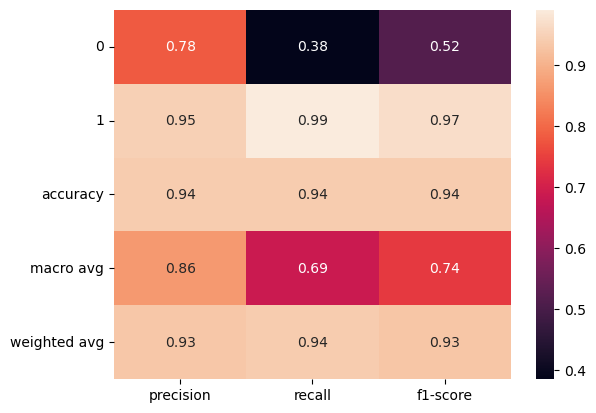

In [35]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)